In [2]:
import torch

from frameworks.distillation.DEIP import load_model
from frameworks.classification.train_single_model import prepare_params, inference_statics
from model import matmul_on_first_two_dim
from model.layerwise_model import pad_const_channel, ConvertibleModel


records = {}

def tensor_static(x, name):
    if name not in records:
        records[name] = []
    records[name].append(x)
    print(name, 'shape', x.shape, 'mean', x.mean(), 'var', x.var(), 'max', x.max(), 'min', x.min())


def super_resolution_test():
    params = {
        'method': 'DEIP_Init',
        'task': 'super-resolution',
        'loss': 'L1',
        'metric': 'psnr255',
        'rgb_range': 255,
        'gpus': 1,
        'weight_decay': 0,
        'lr_scheduler': 'OneCycLR',
        'optimizer': 'Adam',
        'teacher_pretrain_path': "/data/pretrained/lightning_models/layerwise_edsrx4_div2k_a0131.ckpt",
        "dataset": {
            'name': "DIV2K",
            'batch_size': 32,
            'patch_size': 96,
            'ext': 'sep',
            'repeat': 20,
            "test_bz": 1,
            'scale': 4,
        },
        'scale': 4,
        'ignore_exist': True,
        'save_model': False,
        'project_name': 'deip_SRx4_baseline',
        'add_ori': 0,
        'init_stu_with_teacher': 0,
        'layer_type': 'normal_no_bn',
        'rank_eps': 0.1,  # 0.05, 0.6, 1, 2
        'seed': 0,
        'num_epochs': 1,
        'max_lr': 5e-4,
        'init_with_teacher_param': 1,
    }
    params = prepare_params(params)
    model = load_model(params)

    # ======= speed statistics ===========
    # model.plain_model = ConvertibleModel.from_convertible_models(model.plain_model).generate_inference_model()
    # inference_statics(model)

    # ======= teacher student difference ========
    x_test = model.val_dataloader().dataset[0][0]
    x_test = torch.stack([x_test], dim=0)
    xs = x_test.detach()
    xt = x_test.detach()
    cnt=0
    with torch.no_grad():
        for layer_s, layer_t, M in zip(model.plain_model[:-1], model.teacher_model[:-1], model.bridges[1:]):
            conv_s, act_s = layer_s.simplify_layer()
            conv_t, act_t = layer_t.simplify_layer()

            xs = conv_s(pad_const_channel(xs))
            xt = conv_t(pad_const_channel(xt))

            xs = act_s(xs)
            xt = act_t(xt)

            pt = M(pad_const_channel(xs))  # approximation of teacher feature map from student feature map

            print('---------layer ', cnt, '--------')
            cnt += 1
            tensor_static(xs, 'student')
            tensor_static(xt, 'teacher')
            tensor_static(pt, 'p_teacher')
            tensor_static(xt - pt, 'diff')

        xs = model.plain_model[-1](pad_const_channel(xs))
        xt = model.teacher_model.sequential_models[-1](pad_const_channel(xt))
        tensor_static(xs, 'final_student')
        tensor_static(xt, 'final_teacher')
        tensor_static(xt - xt, 'final_diff')

        print("---------full test--------")
        ps = model(x_test)
        pt = model.teacher_model(x_test)
        tensor_static(ps, 'final_student')
        tensor_static(pt, 'final_teacher')
        tensor_static(ps - pt, 'final_diff')
    return model

In [3]:
import random
random.seed(0)
model = super_resolution_test()

using method  DEIP_Init
dataset_params: {'batch_size': 32, 'total_batch_size': 32, 'workers': 4, 'name': 'DIV2K', 'patch_size': 96, 'ext': 'sep', 'repeat': 20, 'test_bz': 1, 'scale': 4, 'dataset_mapping': (0, 1, 2), 'dataset_transforms': (0, 1, 1)}
Preprocessing high resolution sr data...
Preprocessing low resolution sr data...
Preprocessing high resolution sr data...
Preprocessing low resolution sr data...
len(dataset): 16000
len(dataset): 10
len(dataset): 10
dataset_params: {'batch_size': 16, 'total_batch_size': 16, 'workers': 4, 'ext': 'sep', 'name': 'DIV2K', 'patch_size': 96, 'repeat': 20, 'scale': 4, 'test_bz': 1, 'dataset_mapping': (0, 1, 2), 'dataset_transforms': (0, 1, 1)}
Preprocessing high resolution sr data...
Preprocessing low resolution sr data...
Preprocessing high resolution sr data...
Preprocessing low resolution sr data...
len(dataset): 16000
len(dataset): 10
len(dataset): 10
fs_shape torch.Size([14, 9216]) fs_min tensor(-196.9388) fs_mean tensor(2.2139e-07)
fs_shape t

---------layer  8 --------
student shape torch.Size([1, 46, 339, 510]) mean tensor(8.6252) var tensor(188.4033) max tensor(121.2405) min tensor(0.)
teacher shape torch.Size([1, 100, 339, 510]) mean tensor(499.9497) var tensor(250215.1719) max tensor(1164.3362) min tensor(-106.4609)
p_teacher shape torch.Size([1, 100, 339, 510]) mean tensor(500.0206) var tensor(250774.8906) max tensor(1083.1550) min tensor(-54.5569)
diff shape torch.Size([1, 100, 339, 510]) mean tensor(-0.0709) var tensor(251.1659) max tensor(136.3342) min tensor(-184.4694)
---------layer  9 --------
student shape torch.Size([1, 68, 339, 510]) mean tensor(6.8910) var tensor(116.7282) max tensor(85.1591) min tensor(0.)
teacher shape torch.Size([1, 150, 339, 510]) mean tensor(666.9971) var tensor(221809.8594) max tensor(1164.3362) min tensor(0.)
p_teacher shape torch.Size([1, 150, 339, 510]) mean tensor(667.4661) var tensor(221738.3594) max tensor(1066.1018) min tensor(-43.8989)
diff shape torch.Size([1, 150, 339, 510]) m

---------layer  24 --------
student shape torch.Size([1, 59, 339, 510]) mean tensor(3.4777) var tensor(47.7578) max tensor(52.6030) min tensor(0.)
teacher shape torch.Size([1, 100, 339, 510]) mean tensor(501.0098) var tensor(249253.2656) max tensor(1164.3362) min tensor(-138.3032)
p_teacher shape torch.Size([1, 100, 339, 510]) mean tensor(500.2824) var tensor(249507.0312) max tensor(1022.2171) min tensor(-40.5177)
diff shape torch.Size([1, 100, 339, 510]) mean tensor(0.7274) var tensor(245.2630) max tensor(153.2422) min tensor(-149.0147)
---------layer  25 --------
student shape torch.Size([1, 94, 339, 510]) mean tensor(3.7763) var tensor(36.3902) max tensor(48.6778) min tensor(0.)
teacher shape torch.Size([1, 150, 339, 510]) mean tensor(669.1277) var tensor(220480.3906) max tensor(1164.3362) min tensor(0.)
p_teacher shape torch.Size([1, 150, 339, 510]) mean tensor(668.8143) var tensor(220999.0625) max tensor(1038.9414) min tensor(-13.2131)
diff shape torch.Size([1, 150, 339, 510]) mea

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

In [7]:
import numpy as np 

def plot_mean_var(name, ax=plt):
    data = records[name]
    x = np.arange(1, len(data)+1)
    y = np.array([d.mean().item() for d in data])
    y_err = np.array([d.var().item()**0.5 for d in data])
    ax.errorbar(x, y, yerr=y_err, fmt='-o')
    ax.set_title(name)
    
def show_all():
    plt.rcParams['figure.dpi'] = 200
    fig, axes = plt.subplots(nrows=2, ncols=2)
    plot_mean_var('student', axes[0][0])
    plot_mean_var('teacher', axes[0][1])
    plot_mean_var('p_teacher', axes[1][1])
    plot_mean_var('diff', axes[1][0])
    fig.tight_layout()
    plt.show()

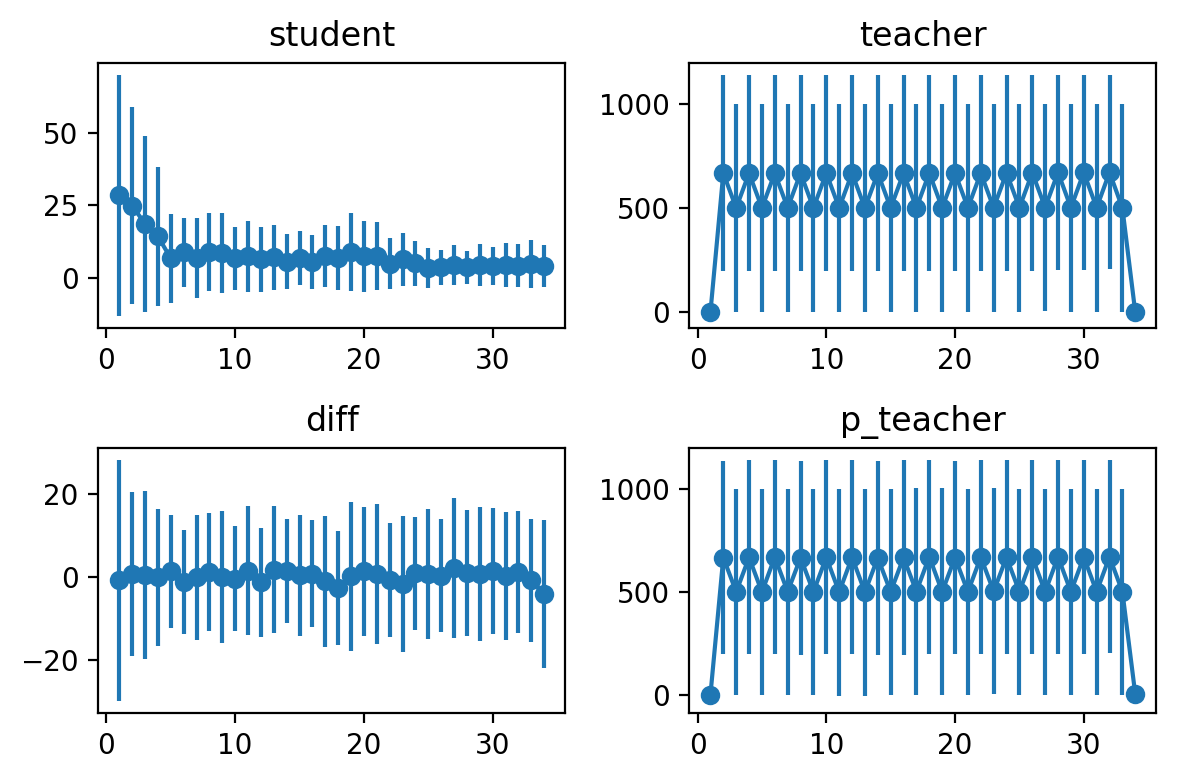

In [8]:
show_all()